In [14]:
import pandas as pd        
from pygam import LogisticGAM
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
#load the breast cancer data set
data = load_breast_cancer()
import pygam
#keep first 6 features only

df = pd.read_csv("https://raw.githubusercontent.com/thistleknot/Python-Stock/master/data/raw/states.csv").set_index('States')

target = "Poverty"
y = df[[target]]
X = df.loc[:, ~df.columns.isin(["States",target])].copy()

#df = pd.DataFrame(data.data, columns=data.feature_names)[['mean radius', 'mean texture', 'mean perimeter', 'mean area','mean smoothness', 'mean compactness']]
#target_df = pd.Series(data.target)
from pygam import ExpectileGAM
from pygam.datasets import mcycle
df.describe()

,Poverty,Infant Mort,White,Crime,Doctors,Traf Deaths,University,Unemployed,Income,Population
count,50.000000,50.000000,50.00000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,5.000000e+01
mean,12.732000,6.830000,81.96200,407.480000,260.276000,1.40440,26.940000,5.270000,51985.100000,6.016154e+06
std,2.939002,1.338786,11.97458,183.633868,64.363415,0.38654,4.761152,1.253933,8592.657934,6.663772e+06
min,7.600000,4.700000,29.70000,118.000000,168.800000,0.76000,17.100000,3.000000,37790.000000,5.232260e+05
25%,10.450000,5.725000,76.15000,278.250000,218.425000,1.14000,24.025000,4.400000,46161.250000,1.779632e+06
50%,12.400000,6.850000,84.55000,345.500000,249.050000,1.37500,26.200000,5.300000,50173.000000,4.313980e+06
75%,14.700000,7.750000,89.85000,520.000000,274.800000,1.62000,29.825000,6.275000,56903.000000,6.490796e+06
max,21.200000,10.600000,96.40000,788.000000,469.000000,2.45000,38.100000,8.400000,70545.000000,3.618591e+07


In [17]:
#X = df[['mean radius', 'mean texture', 'mean perimeter', 'mean area','mean smoothness', 'mean compactness']]
#y = target_df
#Fit a model with the default parameters
#gam = LogisticGAM().fit(X, y)
#gam = gam.LinearGAM(n_splines=10).gridsearch(X, y)
gam = gam.LinearGAM(n_splines=10).fit(X, y)

In [20]:
#gam.accuracy(X, y)
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     15.4015
Link Function:                     IdentityLink Log Likelihood:                                   -93.3727
Number of Samples:                           50 AIC:                                              219.5484
                                                AICc:                                             237.0589
                                                GCV:                                                4.7216
                                                Scale:                                              2.2073
                                                Pseudo R-Squared:                                   0.8196
Feature Function                  Lam

C:\Users\User\AppData\Local\Temp/ipykernel_19656/4058065242.py:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [4]:
#gam50 = ExpectileGAM(expectile=0.5).gridsearch(X.values, y)

In [5]:
#XX = gam50.generate_X_grid(term=1, meshgrid=True)

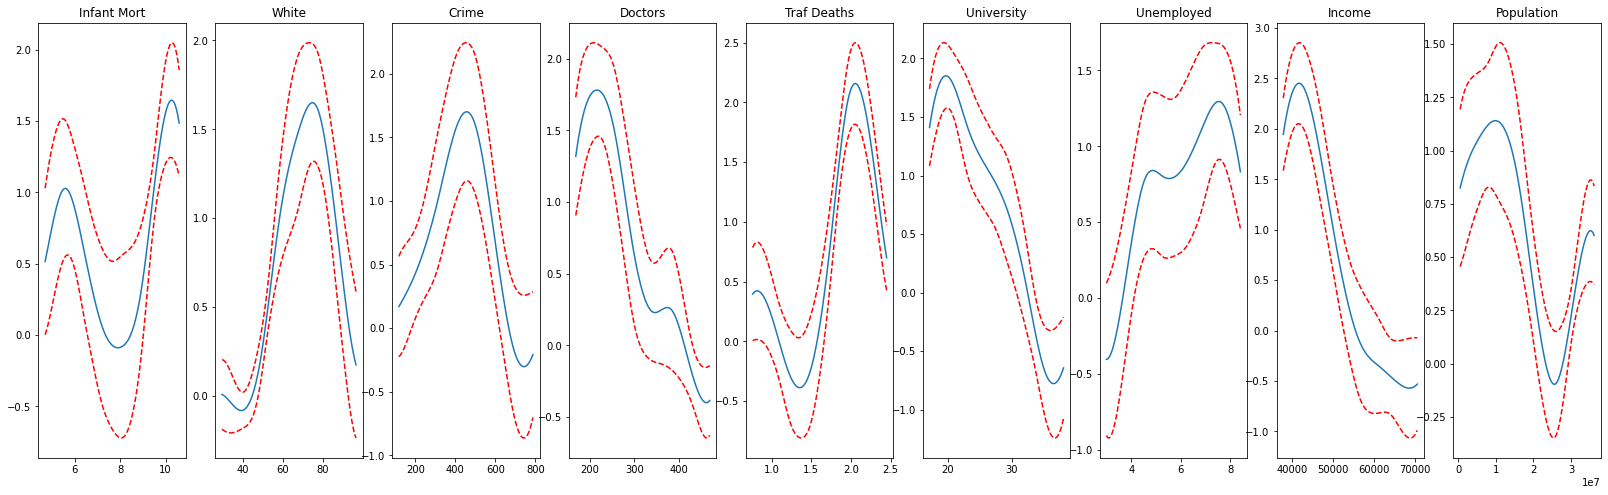

In [26]:
plt.rcParams['figure.figsize'] = (28, 8)
fig, axs = plt.subplots(1, len(X.columns))
titles = X.columns
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX,   width=.95)[1], c='r', ls='--')
    #if i == 0:
        #ax.set_ylim(-100,100)
    ax.set_title(titles[i])    
#fig
